In [2]:
import geopandas as gpd
import osmnx as ox
import pandas as pd
import numpy as np
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import contextily as ctx
main_dir = 'C:/Users/jtrum/world_bank/'
aoi = gpd.read_file(main_dir + 'data/aoiLuanda.geojson')
catchment = gpd.read_file(main_dir + 'data/catchment.geojson')
aoi = aoi.to_crs(epsg=4326)
catchment = catchment.to_crs(epsg=4326)

c:\Users\jtrum\miniconda3\envs\wash\lib\site-packages\geopandas\_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
C:\Users\jtrum\AppData\Local\Temp\ipykernel_19840\3597108215.py:1: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. Howeve

In [3]:
#make fishnet grid
def createGrid(polygon, gridSize):
    xmin, ymin, xmax, ymax = polygon.bounds #creates bounding box of 'co' polygon
    rows = int(np.ceil((ymax-ymin)/gridSize)) #number of rows
    cols = int(np.ceil((xmax-xmin)/gridSize)) #number of columns
    polygons = [] #empty list to hold polygons
    for i in range(cols):
        for j in range(rows):
            polygons.append(Polygon([(xmin+i*gridSize, ymin+j*gridSize), 
                                     (xmin+(i+1)*gridSize, ymin+j*gridSize), 
                                     (xmin+(i+1)*gridSize, ymin+(j+1)*gridSize), 
                                     (xmin+i*gridSize, ymin+(j+1)*gridSize)]))
    grid = gpd.GeoDataFrame({'geometry':polygons})
    grid.crs = {'init':'epsg:4326'}
    grid = grid[grid.geometry.within(polygon)] #keep only grid cells within 'co' polygon
    return grid

#determine distance to nearest water infrastructure point for each grid cell
def distance_to_nearest(row, destination, val):
    #row is a row of the grid dataframe
    #destination is the water infrastructure point dataframe
    #val is the value to return if there are no water infrastructure points
    if len(destination) == 0:
        return val
    else:
        dist = destination.distance(row['geometry'])
        return dist.min()

In [4]:
tags_list = [
    {'waterway': True},
    {'landuse': ['reservoir', 'basin']},
    {'amenity': ['drinking_water', 'watering_place', 'water_point']},
    {'man_made': ['water_well', 'water_tower', 'water_works', 'reservoir_covered', 'storage_tank', 'monitoring_station', 'wastewater_plant', 'watermill', 'pipeline']}
]
dfs = []
for tags in tags_list:
    data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
    data = data[['geometry']]
    data['feature'] = list(tags.keys())[0]  # extract the feature type from the tags
    dfs.append(data)
water_infrastructure = pd.concat(dfs, ignore_index=True)
water_infrastructure = gpd.GeoDataFrame(water_infrastructure, geometry='geometry', crs=aoi.crs)
water_infrastructure['layer'] = water_infrastructure['feature'].apply(lambda x: 1 if x == 'waterway' else 0)

C:\Users\jtrum\AppData\Local\Temp\ipykernel_19840\2850867749.py:11: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
C:\Users\jtrum\AppData\Local\Temp\ipykernel_19840\2850867749.py:11: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. Use these instead. The `geometries` module and function names are deprecated and will be removed in a future release.
  data = ox.geometries_from_polygon(aoi.geometry[0], tags=tags)
C:\Users\jtrum\AppData\Local\Temp\ipykernel_19840\2850867749.py:11: UserWarning: The `geometries` module and `geometries_from_X` functions have been renamed the `features` module and `features_from_X` functions. 

In [5]:
water_infrastructure = water_infrastructure.to_crs(epsg=32632)
aoi = aoi.to_crs(epsg=32632)
catchment = catchment.to_crs(epsg=32632)
water_infrastructure_0 = water_infrastructure[water_infrastructure['layer'] == 0].reset_index().drop(columns=['index'])
water_infrastructure_0['geometry'] = water_infrastructure_0['geometry'].centroid #take centroids of all of the polygons in water_infrastructure_0 to get point data
#make a subset of water_infrastructure to include only 1 values in the 'layer' column
water_infrastructure_1 = water_infrastructure[water_infrastructure['layer'] == 1].reset_index().drop(columns=['index'])

In [6]:
gridSize = 750 #grid size in meters
grid = createGrid(aoi.geometry[0], gridSize)

c:\Users\jtrum\miniconda3\envs\wash\lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [7]:
grid = grid.reset_index().rename(columns={'index':'grid_id'}) 
grid['dist_to_water_infrastructure'] = grid.apply(lambda row: distance_to_nearest(row, water_infrastructure_0, 0), axis=1)
grid['dist_to_water_infrastructure'] = grid['dist_to_water_infrastructure'].astype(int)   
grid

,grid_id,geometry,dist_to_water_infrastructure
0,141,"POLYGON ((939824.27156 -1008601.89295, 940574....",23523
1,142,"POLYGON ((939824.27156 -1007851.89295, 940574....",23035
2,143,"POLYGON ((939824.27156 -1007101.89295, 940574....",22562
3,144,"POLYGON ((939824.27156 -1006351.89295, 940574....",22104
4,148,"POLYGON ((939824.27156 -1003351.89295, 940574....",20447
...,...,...,...
4082,9732,"POLYGON ((1008074.27156 -981601.89295, 1008824...",22096
4083,9733,"POLYGON ((1008074.27156 -980851.89295, 1008824...",21792
4084,9734,"POLYGON ((1008074.27156 -980101.89295, 1008824...",21511
4085,9837,"POLYGON ((1008824.27156 -981601.89295, 1009574...",22779


In [20]:
grid=grid.to_crs(epsg=32632)

In [21]:
print(water_infrastructure_1.crs)
print(grid.crs)
print(aoi.crs)
print(catchment.crs)
print(water_infrastructure_0.crs)

EPSG:32632
EPSG:32632
EPSG:4326
EPSG:32632
EPSG:32632


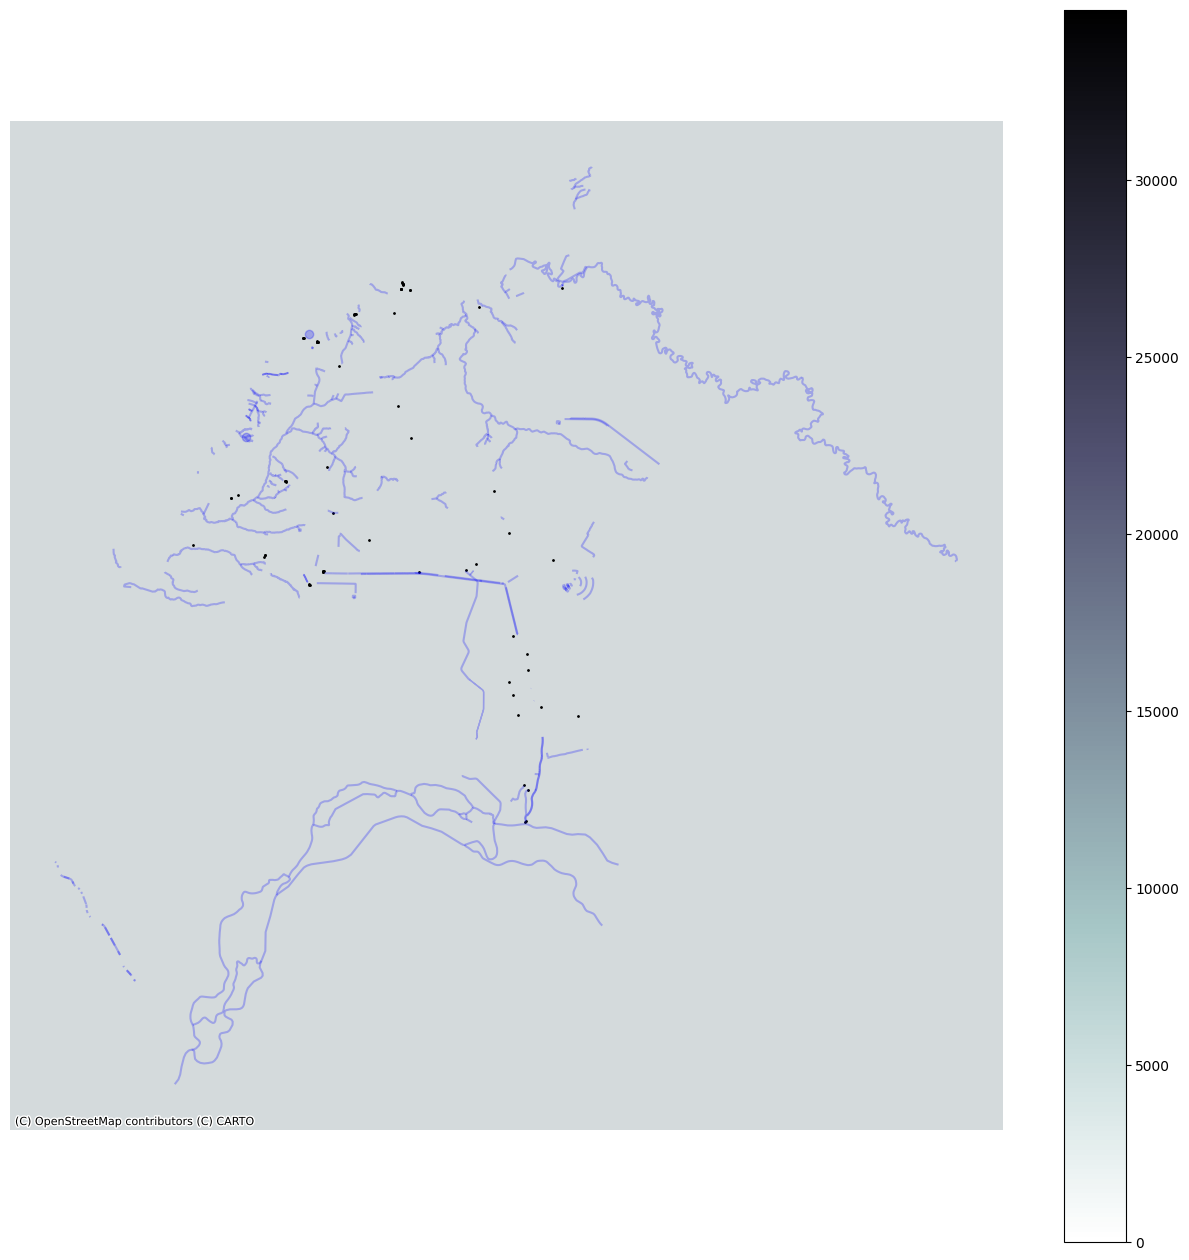

In [26]:
#ax = catchment.plot(color='black', edgecolor='black', alpha=0.1)
ax = grid.plot(column='dist_to_water_infrastructure', cmap='bone_r', legend=True, figsize=(16, 16), aspect='equal')
ax = water_infrastructure_1.plot(ax=ax, color='blue', alpha=0.25, edgecolor='blue')
#add basemap
# add points of water infrastructure
ax = water_infrastructure_0.plot(ax=ax, alpha=1, color='black', markersize=1, edgecolor='black')
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron, zoom=13)
# No ticks
ax.set_xticks([])
ax.set_yticks([])
# No frame
ax.set_frame_on(False)
# # Change font to Helvetica
# plt.rcParams['font.family'] = 'Arial'
# # Add title
# plt.title('Distance to Nearest Water\n Infrastructure Point in Luanda, Angola', fontsize=16);


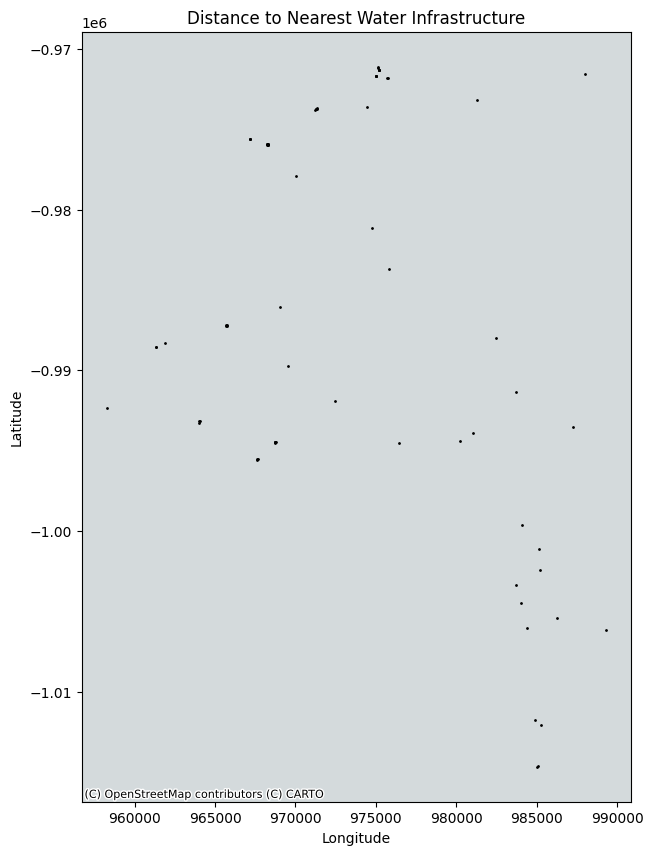

In [25]:
import contextily as ctx
import matplotlib.pyplot as plt

# Create the map figure and axes
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the grid with color based on 'dist_to_water_infrastructure' column
grid.plot(column='dist_to_water_infrastructure', cmap='bone_r', ax=ax)

# Plot the points in water_infrastructure_0
water_infrastructure_0.plot(ax=ax, color='red', markersize=5)

# Add contextily basemap
ctx.add_basemap(ax, source=ctx.providers.CartoDB.Positron)

# Set axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Distance to Nearest Water Infrastructure')

# Show the map
plt.show()
